In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd

# Load Data

In [3]:
from enfobench.dataset import DemandDataset

ds = DemandDataset("data")

In [4]:
unique_ids = ds.metadata_subset.list_unique_ids()

In [5]:
len(unique_ids)

100

In [6]:
unique_id = unique_ids[0]
unique_id

'70aec446c47486f3'

In [7]:
target, _, metadata = ds.get_data_by_unique_id(unique_id)

In [8]:
target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24320 entries, 2012-10-09 08:30:00 to 2014-02-28 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       24317 non-null  float64
dtypes: float64(1)
memory usage: 380.0 KB


# Make external forecasts based on covariates

# Create Dataset

In [9]:
from enfobench.dataset import Dataset

univariate_dataset = Dataset(
    target=target.loc["2012-01-01":"2013-12-31"],
    past_covariates=None,
    future_covariates=None,
    metadata=metadata
)

# Create Model

In [10]:
from enfobench.evaluation import AuthorInfo, ModelInfo, ForecasterType
from enfobench.evaluation.utils import create_forecast_index

class ExampleModel:
    
    def __init__(self, param1: int):
        self.param1 = param1

    def info(self):
        return ModelInfo(
            name="TestModel",
            authors=[
                AuthorInfo(name="Attila Balint")
            ],
            type=ForecasterType.point,
            params={
                "param1": 1,
            },
        )

    def forecast(
        self,
        horizon: int,
        history: pd.DataFrame,
        past_covariates=None,
        future_covariates=None,
        level=None,
        **kwargs,
    ):
        index = create_forecast_index(history, horizon)
        return pd.DataFrame(
            index=index,
            data={
                "yhat": np.full(horizon, fill_value=history["y"].mean()) + self.param1,
            }
        )

In [11]:
model = ExampleModel(1)

# Perform crossvalidation on your model locally

In [18]:
from enfobench.evaluation import cross_validate

crossval_df = cross_validate(
    model, 
    univariate_dataset,
    start_date=pd.Timestamp("2013-01-01T00:00:00"),
    end_date=pd.Timestamp("2013-02-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"), 
    step=pd.Timedelta("1 day"), 
)

100%|██████████| 30/30 [00:00<00:00, 53.29it/s]


In [19]:
crossval_df.head()

,cutoff_date,timestamp,yhat,y
0,2013-01-01,2013-01-01 00:30:00,1.164622,0.303
1,2013-01-01,2013-01-01 01:00:00,1.164622,0.085
2,2013-01-01,2013-01-01 01:30:00,1.164622,0.270
3,2013-01-01,2013-01-01 02:00:00,1.164622,0.084
4,2013-01-01,2013-01-01 02:30:00,1.164622,0.184


# Evaluate metrics

In [20]:
from enfobench.evaluation import evaluate_metrics
from enfobench.evaluation.metrics import mean_absolute_error, mean_bias_error

In [21]:
evaluate_metrics(
    crossval_df,
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    }
)

,MAE,MBE,weight
0,1.009067,1.008643,1.0


In [22]:
metrics = evaluate_metrics(
    crossval_df,
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    },
    groupby="cutoff_date",
)
metrics

100%|██████████| 30/30 [00:00<00:00, 46.45it/s]


,cutoff_date,MAE,MBE,weight
0,2013-01-01,0.961201,0.961201,1.0
1,2013-01-02,0.942087,0.941597,1.0
2,2013-01-03,0.943087,0.942621,1.0
3,2013-01-04,0.999754,0.999754,1.0
4,2013-01-05,0.985921,0.976416,1.0
5,2013-01-06,1.019952,1.019952,1.0
6,2013-01-07,1.054776,1.054776,1.0
7,2013-01-08,1.025911,1.023660,1.0
8,2013-01-09,1.053617,1.053617,1.0
9,2013-01-10,1.012036,1.012036,1.0


<Axes: >

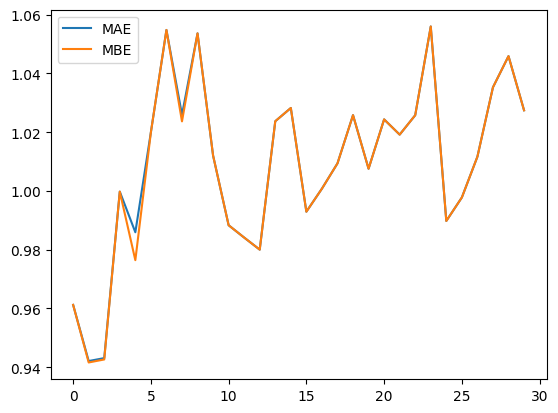

In [23]:
metrics[['MAE', 'MBE']].plot()